# Dependancies

This section sets up imports and users data location

In [ ]:
#Set up drive/folder. 
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
## Loading imports
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import pickle

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import keras.activations
from tensorflow import keras
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten, Dropout, MaxPool2D

from torch.autograd import Variable
from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize
from skimage.filters import gaussian
from skimage.util import random_noise
from sklearn.model_selection import train_test_split

#
import sys
#Append your system path
sys.path.append(os.path.join('drive/My Drive/'))

In [ ]:
#Define your driver
drive_path = 'drive/My Drive/'
#Define image size
size = 150

#Check for Cuda
use_cuda = torch. cuda. is_available()
print(use_cuda)

False


# Classes and functions
This section defines every Class and function used



In [ ]:
#Functions for image augmentation

def flip_image(image):
  return(np.fliplr(image))

def image_blur(image):
  sigma = np.random.uniform(0.7, 1.5)
  return gaussian(image,sigma=sigma,multichannel=True)

def image_noise(image):
  sigma = np.random.uniform(0.05, 0.8)
  return random_noise(image,var=sigma**2)

def image_high_brightness(image):
  randomBrightness = np.random.uniform(50, 100)
  return image + (randomBrightness/255)

def high_contrast(image):
  randomContrast = np.random.uniform(1.1, 2)
  return image * randomContrast

def low_contrast(image):
  randomContrast = np.random.uniform(0.5, 0.9)
  return image * randomContrast

## Datebase

In [ ]:
class Database():
    #Takes paths for pothole and road as input
    def __init__(self, pothole_path, road_path, image_shape=(size, size)):

        self.image_shape = image_shape

        #Start of creating the main data by combinng and shuffling all data
        imagesR, labelsR, imagesP, labelsP = self._combineData(pothole_path, road_path)

        print("Total Observations:\t", len(imagesR+imagesP))

        self.imagesR = imagesR
        self.labelsR = labelsR
        self.imagesP = imagesP
        self.labelsP = labelsP

    @classmethod
    def split_data(self, split_percantage, test_size, imagesR, labelsR, imagesP, labelsP):
      #Setting different lengths to know where to split the data for training, test and vali
      
      imagesPs = imagesP[:len(imagesP)-test_size]

      size = round((len(imagesPs)*split_percantage))

      images = imagesR[:size] + imagesP[:size] 
      labels = labelsR[:size] + labelsP[:size] 

      restImages = imagesR[size:len(imagesR)] + imagesP[size:len(imagesP)] 
      restlabels = labelsR[size:len(labelsR)] + labelsP[size:len(labelsP)] 

      seed = 68
      np.random.seed(seed)
      np.random.shuffle(images)
      np.random.seed(seed)
      np.random.shuffle(labels)
      np.random.seed(seed)
      np.random.shuffle(restImages)
      np.random.seed(seed)
      np.random.shuffle(restlabels)


      test_max = len(restImages) - test_size
      max = len(restImages)

      aug_img, aug_label = self._add_augmentation(labels, images)

      #Use augmented images
      self.train = self._format_arrays(aug_img, aug_label)

      #Do not use augmented images     
      #self.train = self._format_arrays(images, labels)
        
      self.val = self._format_arrays(restImages[:test_max], restlabels[:test_max])
      
      self.test = self._format_arrays(restImages[test_max:max], restlabels[test_max:max])

    def _format_arrays(ar, ar2):
      data = dict()

      img_tot_shp = tuple([len(ar)] + list(ar[0].shape))
      
      data['images'] = np.zeros(img_tot_shp, dtype='float32')
      data['ids'] = np.zeros((len(ar),), dtype='int32')
      data['labels'] = np.zeros((len(ar),), dtype='str')

      for i, x in enumerate(ar):
        try:
          if(ar2[i] == ''):
            print("error")
          else:
            data['images'][i] = x 
            data['ids'][i] = i
            if(ar2[i] == ''):
              ar2[i] = '0'
            data['labels'][i] = ar2[i]
        except Exception as e:
          pass        

      data['images'] = data['images']  
      return data     
      
    @classmethod
    def add_lists(self, rimages, rlabes, images, labels):
      self.images = rimages + images
      self.labels = rlabes + labels
      print("Total Observations:\t", len(self.images))

    def _combineData(self, pot_path, road_path):
      #Create new arrays for images and labels
      image_road_image = [];
      image_road_label = [];

      image_hole_image = [];
      image_hole_label = [];

      #We label clean roads with 0 and potholes with 1
      for image in pot_path:
        image = imread(image)
        image = resize(image, output_shape=self.image_shape, mode='reflect', anti_aliasing=True)
        image_hole_image.append(image)
        image_hole_label.append('1')
      
      for image in road_path:
        image = imread(image)
        image = resize(image, output_shape=self.image_shape, mode='reflect', anti_aliasing=True)
        image_road_image.append(image)
        image_road_label.append('0')

      #Informartion about the input Data. We should expect around the same amount for each. 
      print("Information on Data")
      print("Images of normal roads:", len(image_road_image))
      print("Images of pothole roads:", len(image_hole_image))

      #Combine the data
      imagesR = image_road_image
      labelsR = image_road_label
      imagesP = image_hole_image
      labelsP = image_hole_label

      print("Shuffling the Data")
      #Shuffling the datasets for future splitting
      seed = np.random.randint(0, 10000)
      np.random.seed(seed)
      np.random.shuffle(imagesR)
      np.random.seed(seed)
      np.random.shuffle(labelsR)
      np.random.seed(seed)
      np.random.shuffle(imagesP)
      np.random.seed(seed)
      np.random.shuffle(labelsP)

      return imagesR, labelsR, imagesP, labelsP

    def _add_augmentation(labels, images):
      images_array = []
      labels_array = []

      maxImages = len(images);

      for i in range(maxImages):

        #Original Image
        images_array.append(images[i])
        labels_array.append(labels[i])
        
        #Flipped Image
        images_array.append(flip_image(images[i]))
        labels_array.append(labels[i])
        
        #Blurred Image
        images_array.append(image_blur(images[i]))
        labels_array.append(labels[i])

        #Noise Image
        images_array.append(image_noise(images[i]))
        labels_array.append(labels[i])
        
        #Bright Image
        images_array.append(image_high_brightness(images[i]))
        labels_array.append(labels[i])
        
        #Contrast Image
        images_array.append(high_contrast(images[i]))
        labels_array.append(labels[i])

      #Shuffling the datasets for future splitting
      seed = np.random.randint(0, 99911)
      np.random.seed(seed)
      np.random.shuffle(images_array)
      np.random.seed(seed)
      np.random.shuffle(labels_array)

      #Return images and labels
      return images_array, labels_array

# Preparation of data

In [ ]:
#Get image path for folders:

og_nom = glob.glob("drive/My Drive/Thesis- Anomaly Detection/yt_roads_0/*")
og_pot =  glob.glob("drive/My Drive/Thesis- Anomaly Detection/yt_pot_1/*")

zoomN = glob.glob("drive/My Drive/Thesis- Anomaly Detection/normal_zoom/*.jpg")
zoomP =  glob.glob("drive/My Drive/Thesis- Anomaly Detection/pothole_zoom/*.jpg")

newPot = glob.glob("drive/My Drive/Thesis- Anomaly Detection/newHole/*.jpg")
newRoad = glob.glob("drive/My Drive/Thesis- Anomaly Detection/newRoad/*.jpg")

#Combine folders
newestP = og_pot + zoomP + newPot
newestN = og_nom + zoomN + newRoad

#Get the size of each. Should be around equal for best results. 
print("Total Observations:\t", len(newestP))
print("Total Observations:\t", len(newestN))

In [ ]:
#If you already have Data you can load it here. 
#If you dont have skip this, run the next code field and the come back and save it for next time!!!

Save = 1
Load = 1

# # Dump the data into a pickle file
if(Save == 1 ):
  if(Load == 0):
    with open(drive_path + 'Thesis- Anomaly Detection/data_150_real.pickle', 'wb') as f:
      pickle.dump(data, f)
  else:
    # # Load the data from a pickle file
    with open(drive_path + 'Thesis- Anomaly Detection/data_150_real.pickle', 'rb') as f:
      data = pickle.load(f)

In [ ]:
#Create Data 

#data = Database(newestP, newestN)

Information on Data
Images of normal roads: 1033
Images of pothole roads: 1026
Shuffling the Data
Total Observations:	 2059


In [ ]:
#Split data
data.split_data(0.7, 150, data.imagesR, data.labelsR, data.imagesP, data.labelsP)


In [ ]:
#Define channels and size
nchannels, rows, cols = 3, size, size
#Delete faulty entries
result = np.where(data.train['labels'] == '')
data.train['labels'][result[0]] = '0'

result = np.where(data.test['labels'] == '')
data.test['labels'][result[0]] = '0'

result = np.where(data.val['labels'] == '')
data.val['labels'][result[0]] = '0'

#Reshape images and get labels.
x_train = data.train['images'].reshape((-1, nchannels, rows, cols))
targets_train = data.train['labels'].astype('int32')

x_valid = data.val['images'].reshape((-1, nchannels, rows, cols))
targets_valid = data.val['labels'].astype('int32')

x_test = data.test['images'].reshape((-1, nchannels, rows, cols))
targets_test = data.test['labels'].astype('int32')

print("Information on dataset")
print("x_train", x_train.shape)
print("targets_train", targets_train.shape)
print("x_valid", x_valid.shape)
print("targets_valid", targets_valid.shape)
print("x_test", x_test.shape)
print("targets_test", targets_test.shape)

Information on dataset
x_train (7356, 3, 150, 150)
targets_train (7356,)
x_valid (683, 3, 150, 150)
targets_valid (683,)
x_test (150, 3, 150, 150)
targets_test (150,)
**AUG**


## Keras

## Original LeNet

In [ ]:
#Original LeNEt
act = 'relu'

model = Sequential()
#Layer 1
model.add(Conv2D(filters=6, kernel_size=(5,5), activation=act, input_shape=(150, 150, 3)))
model.add(MaxPooling2D(2,2))
#Layer 2
model.add(Conv2D(filters=16, kernel_size=(5,5), activation=act))
model.add(MaxPooling2D(2,2))
#Layer 3
model.add(Flatten())
model.add(Dense(120, activation=act))
#Layer 4
model.add(Dense(84, activation=act))
model.add(Dense(2, activation='sigmoid'))

## HA LeNet

In [ ]:
#HA LeNet
act = 'relu'

model = Sequential()
#Layer 1
model.add(Conv2D(filters=32, kernel_size=(3,3), activation= act, input_shape=(size, size, 3)))
model.add(MaxPooling2D(2,2))
#Layer 2
model.add(Conv2D(filters=64, kernel_size=(3,3), activation= act))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation= act))
model.add(MaxPooling2D(2,2))

#Layer 3
model.add(Flatten())
model.add(Dropout(0.4))
#Layer 4
model.add(Dense(512, activation=act))
model.add(Dense(2, activation='sigmoid'))

## Original VGG

In [ ]:
#Original VGG
act = "relu"

model = Sequential()

model.add(Conv2D(64, (3,3), activation = act, padding='same', input_shape=(150,150,3)))
model.add(Conv2D(64, (3,3), activation = act, padding='same'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, (3, 3), activation=act,padding='same')) 
model.add(Conv2D(128, (3, 3), activation=act,padding='same')) 
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), activation=act,padding='same')) 
model.add(Conv2D(256, (3, 3), activation=act,padding='same')) 
model.add(Conv2D(256, (3, 3), activation=act,padding='same')) 
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, (3, 3), activation=act,padding='same'))
model.add(Conv2D(512, (3, 3), activation=act,padding='same')) 
model.add(Conv2D(512, (3, 3), activation=act,padding='same')) 
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, (3, 3), activation=act,padding='same')) 
model.add(Conv2D(512, (3, 3), activation=act,padding='same')) 
model.add(Conv2D(512, (3, 3), activation=act,padding='same')) 
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(256, activation=act))
model.add(Dense(128, activation=act))
model.add(Dense(2, activation='softmax'))

## HA VGG

In [ ]:
#HA VGG
act = "relu"

model = Sequential()

model.add(Conv2D(64, (3,3), activation = act, padding='same', input_shape=(150,150,3)))
model.add(Conv2D(64, (3,3), activation = act, padding='same'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, (3, 3), activation=act,padding='same')) 
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), activation=act,padding='same')) 
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, (3, 3), activation=act,padding='same'))

model.add(Flatten())

model.add(Dropout(0.6))

model.add(Dense(128, activation=act))
model.add(Dense(2, activation='softmax'))

## HACNN

In [ ]:
#HACNN
act = "relu"

model = Sequential()

model.add(Conv2D(64, (4,4), activation = act, input_shape=(150,150,3)))
model.add(Conv2D(64, (3, 3), activation=act)) 
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64, (3, 3), activation=act)) 
model.add(Conv2D(64, (3, 3), activation=act)) 
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation=act)) 
model.add(Conv2D(128, (3, 3), activation=act)) 
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation=act)) 
model.add(MaxPooling2D((1, 1)))

model.add(Conv2D(64, (2, 2), activation=act)) 
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(32, (2, 2), activation=act)) 

model.add(Flatten())

model.add(Dropout(0.6))

model.add(Dense(500, activation=act))

model.add(Dense(2, activation='sigmoid'))

## Final Model

In [ ]:
#Final Model
model = Sequential()

model.add(Conv2D(32, (2,2), activation = act, input_shape=(150,150,3)))
model.add(Conv2D(64, (2, 2), activation=act)) 
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(32, (2, 2), activation=act)) 
model.add(Conv2D(64, (2, 2), activation=act)) 
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (2, 2), activation=act))
model.add(Conv2D(128, (2, 2), activation=act)) 
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (2, 2), activation=act))
model.add(Conv2D(256, (2, 2), activation=act)) 
model.add(MaxPooling2D((2, 2)))


model.add(Conv2D(32, (2, 2), activation=act)) 

model.add(Flatten())

model.add(Dense(677, activation=act))

model.add(Dropout(0.4))

model.add(Dense(2, activation='sigmoid'))

## Model Trainning

In [ ]:
lr = 0.00007

opt = keras.optimizers.Adam(learning_rate=lr)

#opt = keras.optimizers.SGD(lr=0.1, momentum=0.0, nesterov=False)  # keras.optimizers.SGD(lr=lr, momentum=0.9)

model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)

tf.config.run_functions_eagerly(True)
x_train = data.train['images'].reshape((-1, cols, rows, nchannels))
targets_train = data.train['labels'].astype('int32')

x_valid = data.val['images'].reshape((-1, cols, rows, nchannels))
targets_valid = data.val['labels'].astype('int32')

training_history=model.fit(x_train, targets_train, epochs=200, batch_size=64, verbose=2,  callbacks=[callback], #callbacks=callbacks_list,
         validation_data=(x_valid, targets_valid))

InternalError: ignored

In [ ]:
x_test = data.test['images'].reshape((-1, cols, rows, nchannels))
y_test = data.test['labels'].astype('int32')

prediction = model.predict(x_test)

y_pred = np.argmax(prediction, axis=1)
#Transform predictions into 1D array 

# Making predictions on test data
prediction = model.predict(x_test)
#Transform predictions into 1D array 
y_pred = np.argmax(prediction, axis=1)

y_test1=y_test
y_test2=[]
for i in y_test1:
  a=i
  y_test2.append(a)  

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test2, y_pred)
print(cm)

TN = cm[0][0] #This was TP, but we want to check if its pothole or not
FN = cm[0][1] #This was FP, but we changed
FP = cm[1][0]
TP = cm[1][1]
print('True positive = ', TP)
print('False positive = ', FP)
print('False negative = ', FN)
print('True negative = ', TN)

Accuracy = (TP+TN)/(TP+FP+TN+FN)
Precision = TP / (TP+FP)
Recall = TP / (TP+FN)
Specificity = TN / (TN+FP)

F1 = (2*Precision*Recall) / (Precision+Recall)

print('Accuracy = ', Accuracy)
print('Precision = ', Precision)
print('Recall = ', Recall)
print('Specificity = ', Specificity)
print('F1 = ', F1)

5/5 [==============================] - 0s 47ms/step
[[47 25]
 [21 57]]
True positive =  57
False positive =  21
False negative =  25
True negative =  47
Accuracy =  0.6933333333333334
Precision =  0.7307692307692307
Recall =  0.6951219512195121
Specificity =  0.6911764705882353
F1 =  0.7125


## Print code

In [ ]:
#Run this to print code
def render_training_history(training_history):
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    accuracy = training_history.history['accuracy']
    val_accuracy = training_history.history['val_accuracy']

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.plot(val_loss, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(accuracy, label='Training set')
    plt.plot(val_accuracy, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.show()

## Visualize layers

In [ ]:
def visualize_conv_layer(layer_name):
  
  layer_output=model.get_layer(layer_name).output  #get the Output of the Layer
  intermediate_model=tf.keras.models.Model(inputs=model.input,outputs=layer_output) #Intermediate model between Input Layer and Output Layer which we are concerned about
  intermediate_prediction=intermediate_model.predict(x_train[510].reshape(1, 150, 150, 3)) #predicting in the Intermediate Node
  
  row_size=4
  col_size=8
  
  img_index=0
  print(np.shape(intermediate_prediction))
    #---------------We will subplot the Output of the layer which will be the layer_name----------------------------------#
  
  fig,ax=plt.subplots(row_size,col_size,figsize=(10,8)) 
  for row in range(0,row_size):
    for col in range(0,col_size):
      ax[row][col].imshow(intermediate_prediction[0, :, :, img_index], cmap='gray')
      img_index=img_index+1 #Increment the Index number of img_index variable
        
print("Function to Visualize the Output has been Created")

In [ ]:
model.summary()

In [ ]:
#The parameter to this function is the layer name from model.summary
visualize_conv_layer('conv2d_26')

# Report stuff

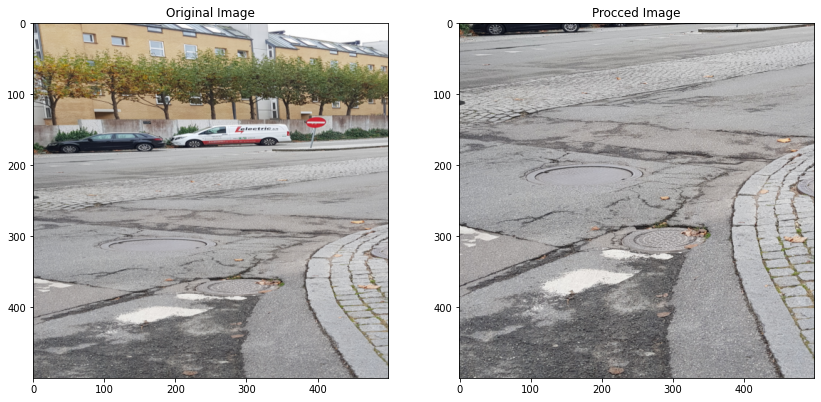

In [ ]:
newImages = glob.glob("drive/My Drive/test123/andre/*.jpg")

image_shape=(500, 500)

image2 = imread(newImages[0])
image2 = resize(image2, output_shape=image_shape, mode='reflect', anti_aliasing=True)
image1 = imread(newImages[1])
image1 = resize(image1, output_shape=image_shape, mode='reflect', anti_aliasing=True)


# https://www.tutorialspoint.com/how-to-display-multiple-images-in-one-figure-correctly-in-matplotlib
plt.figure(figsize=(12, 12))
rows, cols = 1, 2
plt.subplot(rows, cols, 1)
plt.title("Original Image")
plt.imshow(image2)
plt.subplot(rows, cols, 2)
plt.title("Procced Image")
plt.imshow(image1)

plt.show()

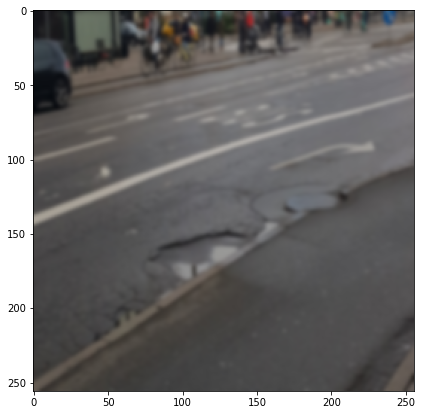

In [ ]:
image_shape=(256, 256)
image2 = imread(zoomP[47])
image2 = resize(image2, output_shape=image_shape, mode='reflect', anti_aliasing=True)
image2 = image_blur(image2)
plt.figure(figsize=(7, 7))
imgplot = plt.imshow(image2)
plt.show()

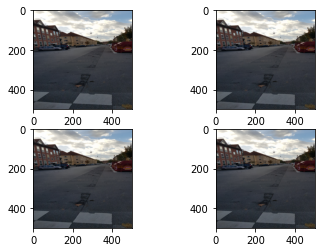

<Figure size 504x504 with 0 Axes>

In [ ]:
f, axarr = plt.subplots(2,2)
plt.figure(figsize=(7, 7))
axarr[0,0].imshow(image2)
axarr[0,1].imshow(image2)
axarr[1,0].imshow(image2)
axarr[1,1].imshow(image2)